
## The Replicator Equation
The replicator equation is one of the most important game dynamics in EGT.
In its the most general mathematical form, the replicator equations are given by

\begin{equation*}
\dot{x_i}=x_i\left [ f(x_i) - \sum_{i=1}^{n}{x_if(x_i)} \right ]\ ,
\end{equation*}

where $x_i$ and $f(x_i)$ is the ratio and fitness of type of $i$ in the population. The equation is defined on $n$-dimensional simplex and the population vector, $x=(x_1, \dots, x_n)$, sums to unity. In biological terms, per capita change in type $i$ (i.e., $\dot{x_i}/x_i$) in a well-mixed population is equal to the  difference between its expected fitness and the weighted average fitness of the population.

For the sake of simplicity it is often assumed that fitness is linearly proportional to the population distribution. In this case the replicator equations can be written as 

\begin{equation*}
\dot{x_i}=x_i\left [ (Ax)_i - x^TAx \right ]\ ,
\end{equation*}

where the matrix $A$ is a payoff matrix with element $A_{ij}$ representing fitness of type $i$ over type $j$.

In [ ]:
import inspect
import sys
from itertools import product
import copy, os

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.spatial.distance import cdist
from shapely.geometry import Polygon, LineString, Point
from tqdm import tqdm

In [ ]:
# define the projection to triangular coordinates
proj = np.array(
    [
        [
            -1 * np.cos(30. / 360. * 2. * np.pi),
            np.cos(30. / 360. * 2. * np.pi),
            0.
        ],
        [
            -1 * np.sin(30. / 360. * 2. * np.pi),
            -1 * np.sin(30. / 360. * 2. * np.pi),
            1.,
        ],
    ]
)

# define the vertices and edges of the simplex
trianglepoints = np.hstack([np.identity(3), np.array([[1.], [0.], [0.]])])
triangleline = np.dot(proj, trianglepoints)

In [ ]:
def random_ics(ic_num):
    # generate initial conditions randomly distributed within the simplex

    # draw points from the unit cube uniformly at random
    points = np.random.random((ic_num, 3))

    # ensure the sum of each point's coordinates is 1
    # (i.e, the point lies in the simplex)
    total = np.sum(points, axis=1).reshape((-1, 1))
    ics = np.divide(points, total)

    return ics

In [ ]:
def edge_ics(ic_num):
    # generate initial conditions very close
    # (but not on) each edge of the simplex

    # generate coordinates
    first = np.linspace(0, 1, ic_num).reshape((-1, 1))
    second = np.subtract(np.ones(ic_num).reshape((-1, 1)), first)
    third = (np.ones(ic_num) * 0.01).reshape((-1, 1))

    # X-Y edge
    points_a = np.concatenate((first, second, third), axis=1)
    total = np.sum(points_a, axis=1).reshape((-1, 1))
    ics = np.divide(points_a, total)
    ics = ics[1:-1]

    # X-Z edge
    points_b = np.concatenate((second, third, first), axis=1)
    total = np.sum(points_b, axis=1).reshape((-1, 1))
    intermediate = np.divide(points_b, total)
    ics = np.concatenate((ics, intermediate[1:-1]), axis=0)

    # Y-Z edge
    points_c = np.concatenate((third, first, second), axis=1)
    total = np.sum(points_c, axis=1).reshape((-1, 1))
    intermediate = np.divide(points_c, total)
    ics = np.concatenate((ics, intermediate[1:-1]), axis=0)

    # get rid of duplicates
    ics = np.unique(ics, axis=1)

    return ics

In [ ]:
def grid_ics():
    """This function generates initial conditions arranged on a grid within
    the simplex. This is more complicated than simply making a lattice in the
    unit cube and then projecting to triangular coordinates because not all
    points will be evenly spaced in the trinagular coordinates (the projection
    is not a linear transformation)."""

    # create a shapely polygon based on the triangle
    poly = Polygon(zip(triangleline[0], triangleline[1]))
    min_x, min_y, max_x, max_y = poly.bounds
    grid_size = 0.12
    n = int(np.ceil(np.abs(max_x - min_x) / grid_size))

    points = []
    for x in np.linspace(min_x, max_x, n)[1:-1]:
        x_line = LineString([(x, min_y), (x, max_y)])
        x_line_intercept_min, x_line_intercept_max = (
            x_line.intersection(poly).xy[1].tolist()
        )
        n_sample = int(
            np.ceil(np.abs(x_line_intercept_max - x_line_intercept_min) / grid_size)
        )
        yy = np.linspace(x_line_intercept_min, x_line_intercept_max, n_sample)
        for y in yy:
            points.append([x, y])

    points = np.array(points)

    # define reference points
    p1, p2, p3 = triangleline.T[:-1]

    # prep a numpy array to be populated below
    starts = np.zeros([len(points), 3])

    # covert 2D trilinear points back to 3D points
    # (to be used in ODE simulations)
    for mm in range(len(points)):
        starts[mm, 0] = np.linalg.norm(np.cross(p3 - p2, p2 - points[mm]))
        starts[mm, 1] = np.linalg.norm(np.cross(p1 - p3, p1 - points[mm]))
        starts[mm, 2] = np.linalg.norm(np.cross(p1 - p2, p2 - points[mm]))

    # make sure there's a point at each vertex
    starts = np.concatenate([starts, np.eye(3)], axis=0)

    # make sure the sum of each point's coordinates sum to 1 so that the point
    # lies in the simplex
    ics = (starts.T / np.sum(starts, axis=1)).T

    return ics

In [ ]:
def proj_to_from(x, y):
    """
    Project points to 3D and back to 2D inside the simplex
    """
    return tuple(
        np.dot(proj, np.array([1 / (1 + x + y), x / (1 + x + y), y / (1 + x + y)]))
    )

In [ ]:
def get_extraploted_line(p1, p2, EXTRAPOL_RATIO=10):
    """
    Creates a line extrapoled in both directions p1->p2 and p2->p1
    """

    a = (
        p2[0] + EXTRAPOL_RATIO * (p1[0] - p2[0]),
        p2[1] + EXTRAPOL_RATIO * (p1[1] - p2[1]),
    )
    b = (
        p1[0] + EXTRAPOL_RATIO * (p2[0] - p1[0]),
        p1[1] + EXTRAPOL_RATIO * (p2[1] - p1[1]),
    )

    return LineString([a, b])

In [ ]:
def equilibria(payoffs, ax):

    # copy the payoffs so we can alter one version and still have the original
    payoff_mat = copy.deepcopy(payoffs)

    # prepare for Bomze's testing (Appendix of Biol Cyb, 1983)
    # transform payoffs to [0 0 0], [a b c], [d e f]
    payoffs[:, 0] -= payoffs[0, 0]
    payoffs[:, 1] -= payoffs[0, 1]
    payoffs[:, 2] -= payoffs[0, 2]

    # define variables for testing following Bomze's conventions
    a = payoffs[1, 0]
    b = payoffs[1, 1]
    c = payoffs[1, 2]
    d = payoffs[2, 0]
    e = payoffs[2, 1]
    f = payoffs[2, 2]

    i = b * f - c * e
    j = a * e - b * d
    k = c * d - a * f

    ####################
    # domain equilibria
    ####################
    line_indicator = 0

    if np.allclose(payoffs, np.zeros((3, 3))):
        pass

    elif i == 0 and j == 0 and k == 0:
        line_indicator = 1
        try:
            if c != 0:
                endpts = [
                    proj_to_from(-0.5, (0.5 * b - a) / c),
                    proj_to_from(0.5, -(a + 0.5 * b) / c),
                ]
                if np.any(~np.isfinite(endpts)):
                    endpts = [
                        proj_to_from(-1, (1 * b - a) / c),
                        proj_to_from(1, -(a + 1 * b) / c),
                    ]
            elif b != 0:
                endpts = [proj_to_from(-a / b, -1), proj_to_from(-a / b, 1)]

            elif f != 0:
                endpts = [
                    proj_to_from(-0.5, (0.5 * e - d) / f),
                    proj_to_from(0.5, -(0.5 * e + d) / f),
                ]
                if np.any(~np.isfinite(endpts)):
                    endpts = [
                        proj_to_from(-1, (1 * e - d) / f),
                        proj_to_from(1, -(1 * e + d) / f),
                    ]
            else:
                endpts = [proj_to_from(-d / e, -1), proj_to_from(-d / e, 1)]

            x_line = get_extraploted_line(*endpts)
            poly = Polygon(zip(triangleline[0], triangleline[1]))
            inter = np.asarray(x_line.intersection(poly).xy)
            ax.plot(
                inter[0], inter[1], zorder=5, color="black", linewidth=4, linestyle="--"
            )
        except:
            pass

    elif (i < 0 and j < 0 and k < 0) or (i > 0 and j > 0 and k > 0):

        x = k / i
        y = j / i
        eq = [1 / (1 + x + y), x / (1 + x + y), y / (1 + x + y)]
        p = eq[1] / eq[0]
        q = eq[2] / eq[0]

        if b * f < c * e:
            # equilibrium is a saddle point
            stability = "saddle"
            eq_face = "grey"
        elif b * p + f * q < 0:
            # equilibrium is a sink
            stability = "sink"
            eq_face = "black"
        elif b * p + f * q > 0:
            # equilibrium is a source
            stability = "source"
            eq_face = "white"
        else:
            # equilibrium is a "centre"
            stability = "centre"
            eq_face = "white"
            eq_plot = np.dot(np.mat(proj), np.array(eq).reshape((3, 1)))
            ax.scatter(
                [eq_plot[0]],
                [eq_plot[1]],
                s=300,
                color="black",
                facecolor="black",
                marker="x",
                zorder=11,
            )

        eq_plot = np.dot(np.mat(proj), np.array(eq).reshape((3, 1)))
        ax.scatter(
            [eq_plot[0]],
            [eq_plot[1]],
            s=300,
            color="black",
            facecolor=eq_face,
            marker="o",
            zorder=10,
        )

    else:
        pass

    ##################
    # edge equilibria
    ##################

    eqs = []
    stabilities = []
    to_test = []
    line_eq_vertex_indicator = [
        -1
    ]  # set to an impossible value unless an edge has an equilibrium

    # first, calculate the equilibria
    subgames = [[0, 1], [1, 2], [0, 2]]
    for i, subgame in enumerate(subgames):
        y = payoff_mat[subgame[0]][subgame[1]]
        z = payoff_mat[subgame[1]][subgame[0]]
        x = payoff_mat[subgame[0]][subgame[0]]
        w = payoff_mat[subgame[1]][subgame[1]]

        eq_num = w - y
        eq_stab_num = -(x - z) * (y - w)
        eq_denom = x - y - z + w

        # infinite numbers of edge equilibria
        if (eq_denom == 0) and (eq_num == 0):
            line_eq_vertex_indicator.extend(subgame)
            eq_subgame = np.zeros((1, 3))
            eq_subgame[0][0] += subgame[0] + subgame[1]

            # plot a white rectangle on that edge to cover up errant arrows
            if eq_subgame[0][0] == 1:
                left, bottom = triangleline[0][0], triangleline[1][0] - 0.05
                width = (
                    (triangleline[0][1] - triangleline[0][0]) ** 2
                    + (triangleline[1][0] - triangleline[1][1]) ** 2
                ) ** 0.5
                angle = 0
                height = 0.05
                edge_nums = [0, 1]

            elif eq_subgame[0][0] == 3:
                left, bottom = triangleline[0][1], triangleline[1][1]
                width = (
                    (triangleline[0][2] - triangleline[0][1]) ** 2
                    + (triangleline[1][2] - triangleline[1][1]) ** 2
                ) ** 0.5
                angle = 120
                height = -0.05
                edge_nums = [1, 2]

            else:
                left, bottom = triangleline[0][0], triangleline[1][0]
                width = (
                    (triangleline[0][0] - triangleline[0][2]) ** 2
                    + (triangleline[1][0] - triangleline[1][2]) ** 2
                ) ** 0.5
                angle = 60
                height = 0.05
                edge_nums = [0, 2]

            # Mask the weird looking arrows popping under edge equilibria
            p = patches.Rectangle(
                (left, bottom),
                width=width,
                height=height,
                angle=angle,
                fill=True,
                zorder=4,
                color="white",
            )
            ax.add_patch(p)

            # make the edge a dotted line to match line domain equilibria
            ax.plot(
                triangleline[0, edge_nums],
                triangleline[1, edge_nums],
                zorder=5,
                color="black",
                linewidth=4,
                linestyle="--",
            )

        # finite numbers of edge equilibria
        if eq_denom == 0:  # avoid a divide by zero error
            eq_subgame = 1  # this may need to be switched to 0
        else:
            eq_subgame = eq_num / eq_denom  # compute the equilibrium position

        if 0 < eq_subgame < 1:  # if there's an equilibria interior to the edge
            # set the coordinates of the equilibrium
            eq_subgame_full = np.zeros((1, 3))
            eq_subgame_full[0][subgame[0]] += eq_subgame
            eq_subgame_full[0][subgame[1]] += 1 - eq_subgame
            eqs.append(eq_subgame_full)

            # make a point to test that's close to the equilibrium but is in the domain
            moved = eq_subgame_full.copy()
            ind = np.argmin(moved)
            moved[0, ind] += 0.01
            moved = np.divide(moved, np.sum(moved))
            to_test.append(moved)

            # compute the stability of the equilibrium algebraically
            if eq_denom != 0:
                eq_subgame_stab = eq_stab_num / eq_denom
            else:
                eq_subgame_stab = eq_stab_num

            # set indicator variables for the equilibrium stability
            if eq_subgame_stab < 0:
                stability = "sink"
            elif eq_subgame_stab > 0:
                stability = "source"
            else:
                stability = "saddle"

            stabilities.append(stability)

    # if there are edge equilibria, test them numerically to get their global stability
    if len(eqs) > 0:
        eq_positions = np.squeeze(np.array(eqs), axis=1)
        testing_positions = np.squeeze(np.array(to_test), axis=1)

        before_distances = np.linalg.norm(eq_positions - testing_positions, axis=1)

        ends = []
        for x in range(len(testing_positions)):
            yout = odeint(
                landscape, testing_positions[x], [0, 1000], args=(payoff_mat,)
            )
            ends.append(yout[1])

        after_distances = np.linalg.norm(eq_positions - np.array(ends), axis=1)
        num_stability = before_distances > after_distances

        for i in range(len(eq_positions)):
            eqs_plot = np.array(np.mat(proj) * eq_positions[i].reshape((3, 1)))

            if line_indicator == 0:
                if num_stability[i] and stabilities[i] is "sink":
                    eq_face = "black"
                elif not num_stability[i] and stabilities[i] is "source":
                    eq_face = "white"
                else:
                    eq_face = "grey"
                ax.scatter(
                    eqs_plot[0],
                    eqs_plot[1],
                    s=300,
                    color="black",
                    facecolor=eq_face,
                    marker="o",
                    zorder=10,
                )
            else:
                continue

    ####################
    # vertex equilibria
    ####################

    evs_x = [np.sign(a), np.sign(d)]
    evs_y = [np.sign(-b), np.sign(e - b)]
    evs_z = [np.sign(-f), np.sign(c - f)]
    evs = [evs_x, evs_y, evs_z]

    for i, vertex in enumerate(evs):
        if vertex[0] == 0 and vertex[1] == 0:
            continue
        elif vertex[0] == 0 or vertex[1] == 0:
            if i in line_eq_vertex_indicator:
                continue
            elif vertex[0] < 0 or vertex[1] < 0:
                # vertex is a sink
                facecolor = "black"
            else:
                # vertex is a source
                facecolor = "white"
        else:
            if vertex[0] == vertex[1] and vertex[0] < 0:
                # vertex is a sink
                facecolor = "black"
            elif vertex[0] == vertex[1] and vertex[0] > 0:
                # vertex is a source
                facecolor = "white"
            else:
                # vertex is a saddle
                facecolor = "grey"

        eq = np.array([0, 0, 0])
        eq[i] += 1
        eq_plot = np.dot(np.mat(proj), np.array(eq).reshape((3, 1)))

        # Plot equilibria
        ax.scatter(
            [eq_plot[0]],
            [eq_plot[1]],
            s=300,
            color="black",
            facecolor=facecolor,
            marker="o",
            zorder=10,
        )

In [ ]:
def get_cols_and_rows(payoff_entries):
    """Determine how many columns and rows the output plot should have based on
    how many parameters are being swept."""

    # make a list of the lengths of each parameter list that are more than one
    # value for that parameter
    lengths = [len(x) for x in payoff_entries if len(x) > 1]

    if len(lengths) == 0:
        # plot as a single subplot
        n_cols, n_rows = 1, 1

    elif len(lengths) == 1:
        # plot as row with increasing parameter going from left to right

        # find the param that has > 1 entry
        longest = [[i, x] for i, x in enumerate(payoff_entries) if len(x) > 1]
        col_params = longest[0][1]

        n_cols, n_rows = len(col_params), 1

    elif len(lengths) == 2:
        # plot as lengths[0] x lengths[1] rectangular grid with increases down and right

        # find the two params that have > 1 entry
        longest = [[i, x] for i, x in enumerate(payoff_entries) if len(x) > 1]
        col_params = longest[0][1]
        row_params = longest[1][1]

        n_cols, n_rows = len(col_params), len(row_params)

    else:
        # plot on an j x j square grid and just leave some blank at the end
        tot_num = 1
        for i in lengths:
            tot_num *= i

        j = 3
        while j ** 2 < tot_num:
            j += 1

        n_cols, n_rows = j, j

    return n_cols, n_rows


In [ ]:
def landscape(x, time, payoffs):
    ax = np.dot(payoffs, x)
    return x * (ax - np.dot(x, ax))

In [ ]:
def custom_to_standard(payoff_func, entries):
    for combo in product(*entries):
        payoff = payoff_func(*combo)
        yield tuple(np.ravel(payoff))

In [ ]:
def plot_static(
    payoff_entries,
    generations=6,
    steps=200,
    background=False,
    ic_type="grid",
    ic_num=100,
    ic_dist=0.05,
    ic_color="black",
    paths=False,
    path_color="inferno",
    eq=True,
    display_parameters=True,
    custom_func=None,
    vert_labels=["X", "Y", "Z"],
):
    """Function to plot static evolutionary game solutions.
    Arguments
    ---------
        payoff_entries (list): list of nine lists containing entries in the payoff
            matrices
        generations (int): the number of epochs to simulate forward the ODEs; default 6
        steps (int): the number of steps simulated per generation; default 200
        background (bool): controls whether the background of the simplex is colored by
            speed; default False
        ic_type (str): the distribution of initial conditions ('random', 'grid', or
            'edge'); default 'grid'
        ic_num (int): the number of initial conditions; default 100
        ic_dist (float): the distance between initial conditions when ic_type =
            'random'; default 0.05
        ic_color (string): the color of each initial condition; default 'black'
        paths (bool): whether the paths taken by each initial condition should be
            displayed; default False
        path_colors (string): the colormap used for the paths for each initial
            condition; default 'inferno'
        eq (bool): whether or not equilibria should be plotted on the simplex;
            default True
        display_parameters (bool): whether or not to print the payoff matrix next to
            the simplex; default True
        custom_func (function): makes the payoffs a function of other parameters;
            default None
        vert_labels (list): list of strings that should label the vertices; default
            ['X', 'Y', 'Z']
    Returns
    -------
        A matplotlib figure object containing the designated simplex.
    More
    ----
    See https://github.com/mirzaevinom/egtplot/blob/master/egtplot_demonstration.ipynb
    for greater detail an examples.
    """
    # check to see if the arguments are of the right form and display a message if not
    if not isinstance(payoff_entries, list):
        sys.exit(
            "payoff_matrices must be a list of lists of each parameter a through i"
        )

    if not isinstance(generations, int):
        sys.exit("gens must be an integer")

    if not isinstance(steps, int):
        sys.exit("steps must be an integer")

    if not isinstance(background, bool) and background not in [0, 1]:
        sys.exit(
            "Background must be a boolean value. \
            Choose 'True' for a shaded background to visualize speed \
            or choose 'False' for a blank background."
        )

    if ic_type not in ["grid", "random", "edge"]:
        sys.exit("ic_place must be 'grid', 'random', or 'edge'")

    if not isinstance(ic_num, int):
        sys.exit("ic_num must be an integer")

    if not isinstance(paths, bool) and paths not in [0, 1]:
        sys.exit(
            "paths must be True for trails to be displayed "
            "or False for arrows to be displayed at the initial conditions."
        )

    if not isinstance(eq, bool) and eq not in [0, 1]:
        sys.exit("eq must be a boolean value")

    if path_color not in plt.colormaps():
        sys.exit(
            "Plotting will fail silently if you do not specify a valid colormap for \
            this argument. Use pyplot.colormaps() to get a list of valid colormaps."
        )

    if not isinstance(display_parameters, bool) and display_parameters not in [0, 1]:
        sys.exit("display_parameters must be a boolean value")

    if not isinstance(vert_labels, list):
        sys.exit("vert_labels must be a list of strings")

    #######################################
    # actually compute and plot the things
    #######################################

    # create all possible payoff matrices from the parameter entry list of lists
    if custom_func is None:
        combinations = product(*payoff_entries)
    elif callable(custom_func):
        combinations = custom_to_standard(custom_func, payoff_entries)
        custom_comb = list(product(*payoff_entries))
    else:
        sys.exit("if provided, custom_func must be callable function")

    # get the asked-for initial conditions
    if ic_type == "grid":
        ics = grid_ics()
    elif ic_type == "random":
        ics = random_uniform_points(ic_num, ic_dist)
        # ics = random_ics(ic_num)
    else:
        ics = edge_ics(ic_num)

    # make certain that there is an initial condition at each point of the simplex
    ics = np.vstack((ics, np.eye(3)))
    ics = np.unique(ics, axis=1)

    # determine the number of rows and columns of subplots
    n_cols, n_rows = get_cols_and_rows(payoff_entries)

    # create the clock to time the simulations
    time = np.linspace(0.0, generations, steps)

    # set the size of the figure
    size = (6 * n_cols, 6 * n_rows)
    fig = plt.figure(figsize=size)
    fontsize = 18 - n_cols

    # create the subplot grid
    gs = gridspec.GridSpec(n_rows, n_cols, hspace=0.2, wspace=0.3)

    # loop through each possible payoff matrix
    j = 0
    for combo in tqdm(combinations):

        # print payoff matrices as a progress indicator
        payoff_mat = np.reshape(combo, (3, 3))

        # create the subplot on which to plot the simplex
        ax = fig.add_subplot(gs[j])
        j += 1

        # prep for the contour map that generates the background shading
        tri_contour = np.zeros([len(ics), 3])

        # Track endpoints to approximate domain equilibrium
        endpoints = np.zeros([len(ics), 2])
        # loop through each initial condition
        for x in range(len(ics)):

            # solve the ODEs and project to triangular coordinates
            yout = odeint(landscape, ics[x], time, args=(payoff_mat,))
            plot_values = np.dot(proj, yout.T)
            xx = plot_values[0]
            yy = plot_values[1]

            endpoints[x] = plot_values[:, -1]

            try:
                dist = np.sqrt(np.sum(np.diff(plot_values, axis=1) ** 2, axis=0))
                dist = np.cumsum(dist)
                tri_contour[x] = [xx[0], yy[0], dist[0]]

                if paths == "False" or paths == 0:
                    # plot arrows if not paths
                    ind = np.abs(dist - 0.075).argmin()

                    # plot arrow shafts
                    ax.plot(
                        xx[: ind + 1],
                        yy[: ind + 1],
                        linewidth=0.5,
                        color=ic_color,
                        zorder=3,
                    )

                    # arrow heads
                    ax.arrow(
                        xx[ind],
                        yy[ind],
                        xx[ind + 1] - xx[ind],
                        yy[ind + 1] - yy[ind],
                        facecolor=ic_color,
                        shape="full",
                        lw=0,
                        length_includes_head=True,
                        head_width=.03,
                        edgecolor="black",
                        zorder=3,
                    )
                else:
                    # plot larger dots at the initial conditions
                    ax.scatter(xx[0], yy[0], color=ic_color, s=15, marker="o", zorder=3)

                    # plot the path each initial condition takes through the simplex
                    ax.scatter(xx, yy, c=time, cmap=path_color, s=1, zorder=3)
            except ValueError:
                continue

        # calculate and plot the edge equilibria if appropriate
        if eq:
            equilibria(payoff_mat, ax)

        # plot the background if appropriate
        if background == "True" or background == 1:
            tri_contour[:, 2] = tri_contour[:, 2] / tri_contour[:, 2].max()
            im = ax.tricontourf(
                tri_contour[:, 0],
                tri_contour[:, 1],
                tri_contour[:, 2],
                100,
                cmap="rainbow",
                vmin=0,
                vmax=1,
                zorder=1,
            )

        # plot the simplex edges
        ax.plot(
            triangleline[0],
            triangleline[1],
            clip_on=False,
            color="black",
            zorder=3,
            linewidth=0.5,
        )

        # display simplex labels
        ax.annotate(
            vert_labels[0],
            xy=(0, 0),
            xycoords="axes fraction",
            ha="right",
            va="top",
            fontsize=fontsize,
            color="black",
        )
        ax.annotate(
            vert_labels[1],
            xy=(1, 0),
            xycoords="axes fraction",
            ha="left",
            va="top",
            fontsize=fontsize,
            color="black",
        )
        ax.annotate(
            vert_labels[2],
            xy=(0.5, 1),
            xycoords="axes fraction",
            ha="center",
            va="bottom",
            fontsize=fontsize,
            color="black",
        )

        # plot the payoff matrix parameters if appropriate
        if display_parameters:
            # a, b, c, d, e, f, g, h, i = combo
            a = np.reshape(combo, [3, 3])

            param_matrix = "\n".join(
                ["".join(["{:7}".format(round(item, 2)) for item in row]) for row in a]
            )
            ax.annotate(
                param_matrix,
                xy=(-0.3, 0.5),
                xycoords="axes fraction",
                fontsize=fontsize,
            )
        if custom_func is not None:
            args = inspect.getfullargspec(custom_func).args
            title_str = (
                "("
                + ", ".join(args)
                + ") = ("
                + ", ".join(map(str, custom_comb[j - 1]))
                + ")"
            )
            ax.set_title(title_str, loc="center", size=fontsize - 2, y=1.1)

        # clean up the plot to make it look nice
        ax.set_xlim([triangleline[0, 0] - 0.1, triangleline[0, 1] + 0.1])
        ax.set_ylim([-0.5 - 0.1, 1.1])
        ax.axis("off")
        ax.set_aspect(1)

    # place a color bar to the side of the subplots if the background is being plotted
    if background == "True" or background == 1:

        # add a colorbar
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
        cbar_ax.set_title("Speed", fontsize=fontsize)
        fig.colorbar(im, cax=cbar_ax)

    return fig

The function `plot_static` takes a list of list of parameters with the first three elements holding lists of values for the zeroth row of the payoff matrix, the next three for the first row, and the final three for the second row. For example, the list of lists `[[a], [b], [c], [d], [e], [f], [g], [h], [i]]` corresponds to the payoff matrix:

\begin{equation*}
\begin{matrix}
a & b & c \\
d & e & f \\
g & h & i.
\end{matrix}
\end{equation*}

For this Q1, we set $a = 2$, $b = 0$, $c = 1$, and so forth.

1it [00:00,  3.62it/s]


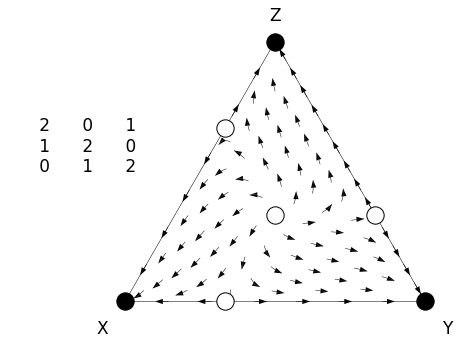

In [ ]:
payoff_entries = [[2], [0], [1], [1], [2], [0], [0], [1], [2]]
simplex = plot_static(payoff_entries)